# Get NDBC buoy's data

Author Henrique P P Pereira

The Realtime directory http://www.ndbc.noaa.gov/data/realtime2/ contains the current (last
45 days) data

The data posted to the NDBC web server are stored in flat files that may be downloaded via HTTP, wget, or Perl/LWP (among other utilities). HTTP is the protocol that should be used.

In general, Realtime data
are the data that have undergone automated quality control checks as they were received in
real time and released on the Global Telecommunications System (GTS). The files are named
station_id.datatype.

The available data types are:

txt for standard meteorological data
drift for meteorological data from drifting buoys
cwind for continuous winds data
spec for spectral wave summaries
data_spec for raw spectral wave data
swdir for spectral wave data (alpha1)
swdir2 spectral wave data (alpha2)
swr1 for spectral wave data (r1)
swr2 for spectral wave data (r2)
adcp for Acoustic Doppler Current Profiler
ocean for oceanographic data
tide for tide data

As an example, the following files would apply to station 41002,
- the standard meteorological data is in 41002.txt
- the continuous winds data is in 41002.cwind
- the spectral wave summary data is in 41002.spec
- the raw spectral wave data is in 41002.data_spec

Not all of these data types are available on each station. All stations should have standard met data (.txt) and buoys should have spectral wave summaries (.spec).

The NDBC Distributed Oceanographic Data System (DODS) makes netCDF files available
to the science community and general public via our website. It uses the Open Source
Project for a Network Data Access Protocol (OPeNDAP) software for data providers to share
data with each other and the end users. This service is available at the following URL:
http://dods.ndbc.noaa.gov/

# wget - Realtime

To retrieve the 42001.txt file from NDBC, use:

wget http://www.ndbc.noaa.gov/data/realtime2/41002.txt

# DODS - nefCDF

Acess via OPeNDAP

The data are in subdirectories by type, then by station within each type. The data types are listed below. Both historical and "real-time" data are available in collections in the station folders. The collections are in separate files for each year of historical data, plus a file for the latest "real-time" data. The file naming convention is SSSSStYYYY.nc, where SSSSS will have the station's ID, t will be the data type, YYYY will be the year of the historical data or 9999 for the latest "real-time" data, and .nc indicates it is a netCDF file. The "real-time" data have not undergone NDBC's final archival quality processing. The term "real-time" is used to be consistent with the labels used on NDBC's main web site. The "real-time" files will contain up to 45 days of the latest data, to provide a continuous time series when coupled with the current year's historical data. Upon each month's final monthly archival quality processing, that month of historical data will be added to the current year file and removed from the 9999 file. There will be no overlaps.

The station folders are groupped under the following data type directories:

adcp - Acoustic Doppler Current Profiler data
adcp2 - MMS Acoustic Doppler Current Profiler data
cwind - Continuous Winds data
dart - Deep-ocean Assessment and Reporting of Tsunamis data
mmbcur - Marsh-McBirney Current Measurements data
ocean - Oceanographic data
pwind - Peak Winds data
stdmet- Standard Meteorological data
swden - Spectral Wave Density data with Spectral Wave Direction data
wlevel - Water Level data


# CDIP
abrir com xray

ds = nc.Dataset('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/219p1/219p1_historic.nc')

import xarray as xr
buoy = xr.open_dataset('http://dods.ndbc.noaa.gov/thredds/dodsC/data/ocean/41024/41024o9999.nc')

df = buoy.to_dataframe()
df.columns



In [324]:
import os
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import numpy as np
import urllib2
%matplotlib inline

In [572]:
'''
Open Realtime data from NDBC website and concatenate with
the existing file

date,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE

Non recent data:
- 41109

'''

#pathname and station names
pathname = os.environ['HOME'] + '/Dropbox/database/ndbc/realtime/'

stations = ['32012','41001','41002','41013','41025','41060','41114',
            '42058','44009','44013','44020','44099','45008','46215',
            '46229','46236','46243','46248','51202']

for station in stations:

    #open realtime data
    data = urllib2.urlopen('http://www.ndbc.noaa.gov/data/realtime2/' + station + '.txt').read()
    data = data.split('\n')

    #create dataframe
    df = pd.DataFrame()
    for line in data[2:]:
        df = pd.concat([df, pd.Series(line.split())], axis=1)
    df = df.T
    df.index = range(len(df))
    df.columns = ['YY'] + data[0].split()[1:]
    df['date'] = pd.to_datetime(df.YY+df.MM+df.DD+df.hh+df.mm, format='%Y%m%d%H%M')
    df = df.drop(['YY','DD','MM','hh','mm'], axis=1)
    df = df.set_index('date')
    df = df.replace('MM','NaN')
    df = df.astype(float)
    df = df.iloc[::-1][1:] #inverte - flipud e retira o primeio valor (nan)

    #feet to meters (WVHT)
    df.WVHT = df.WVHT * 0.3048

    #df.to_csv(pathname + station + '.csv', na_rep='NaN')

    #load exist file
    old = pd.read_csv(pathname + station + '.csv', sep=',', parse_dates=['date'], index_col=['date'])

    #concatenate new and old file
    df = pd.concat([df, old], axis=0)

    #save new (concatated) file
    df.to_csv(pathname + station + '.csv', na_rep='NaN')
    df = df.drop_duplicates()

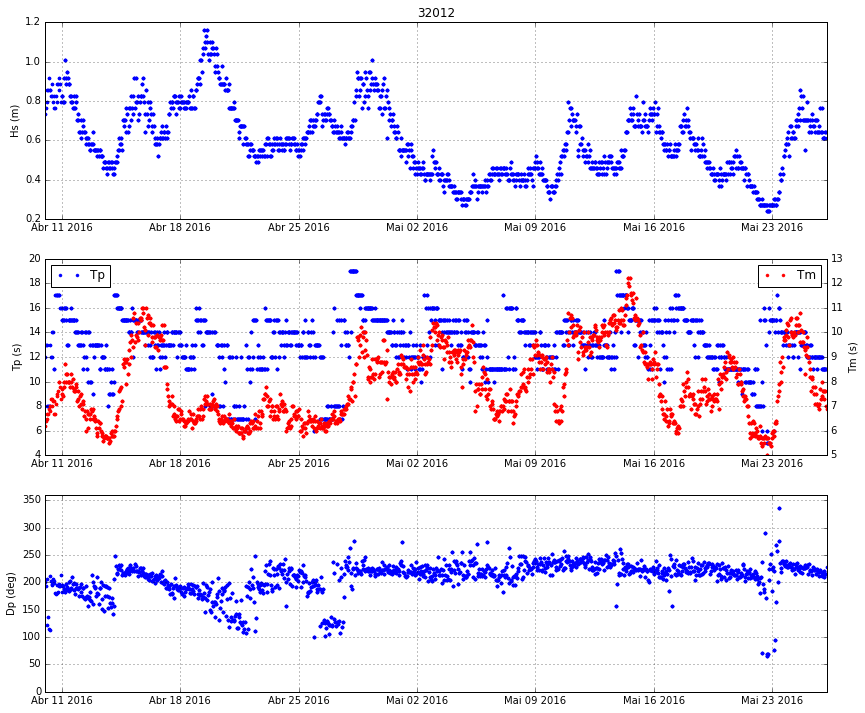

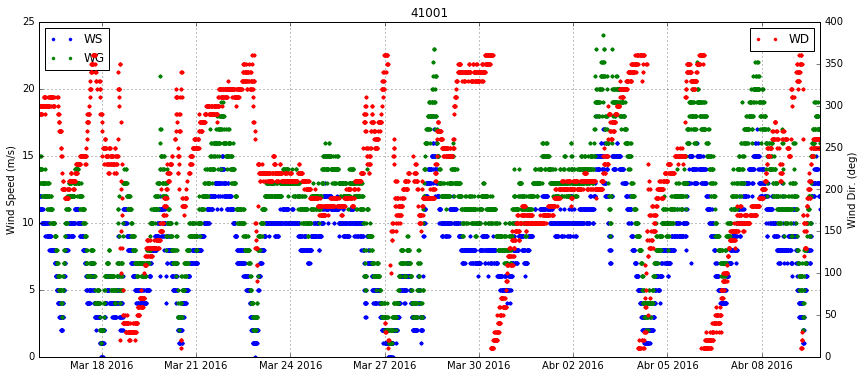

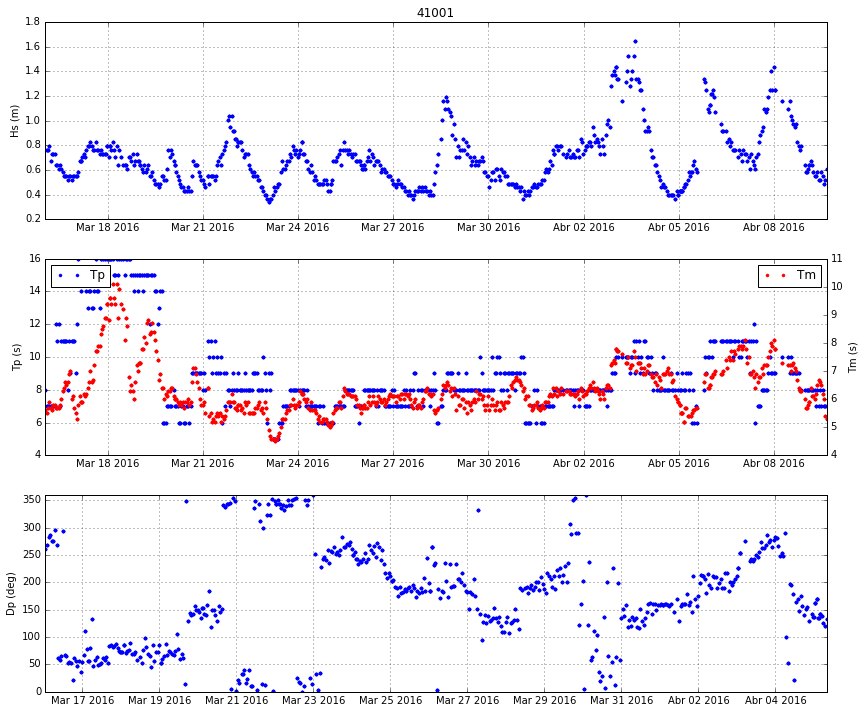

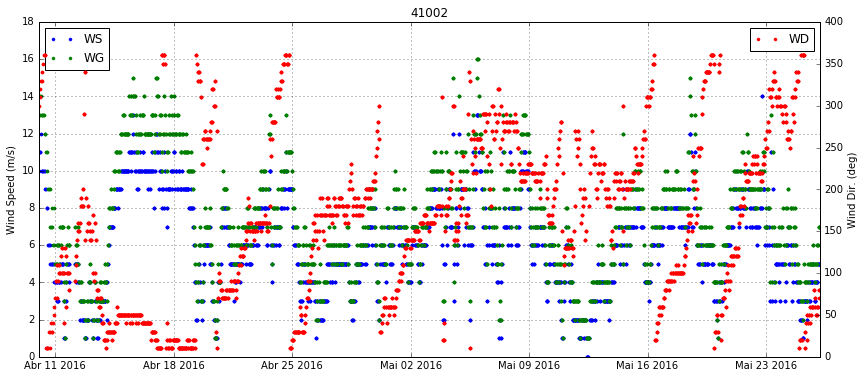

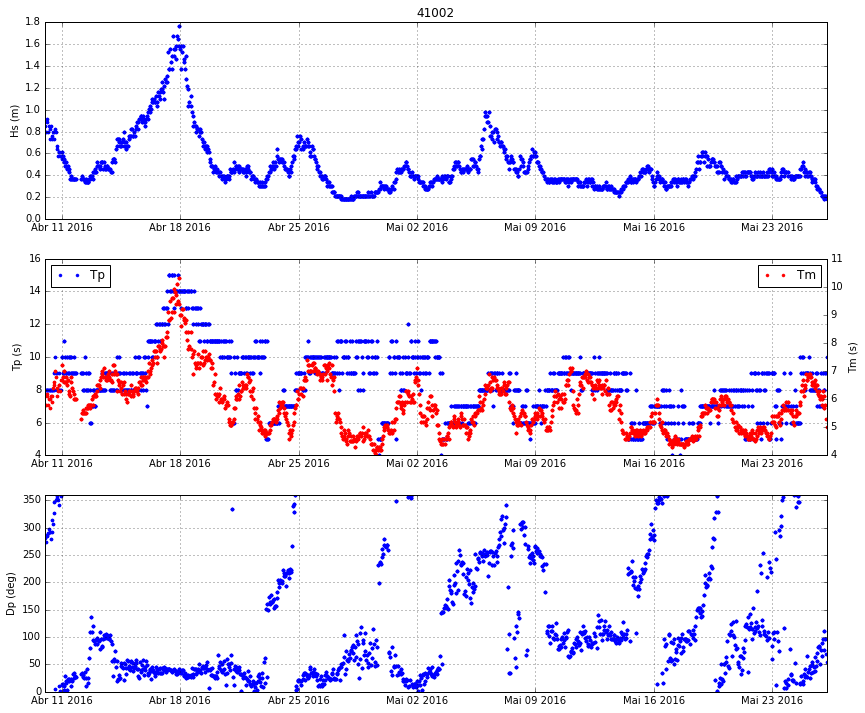

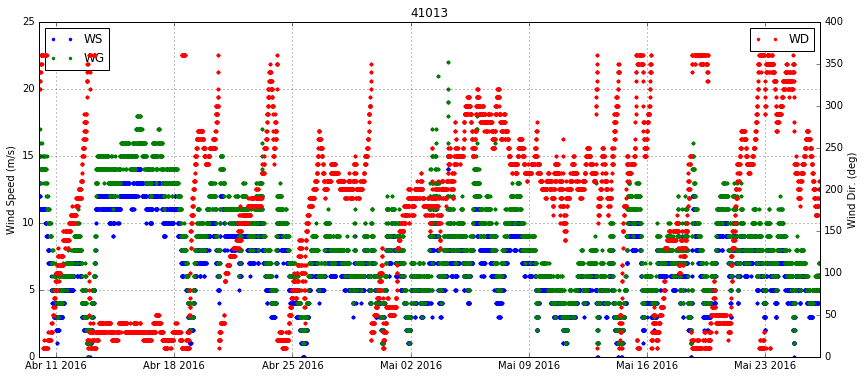

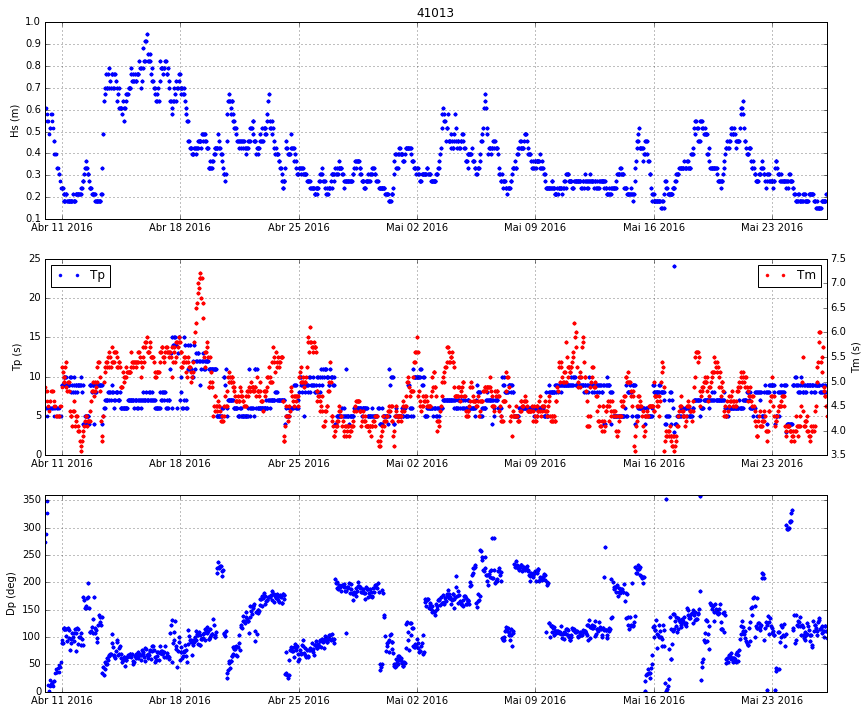

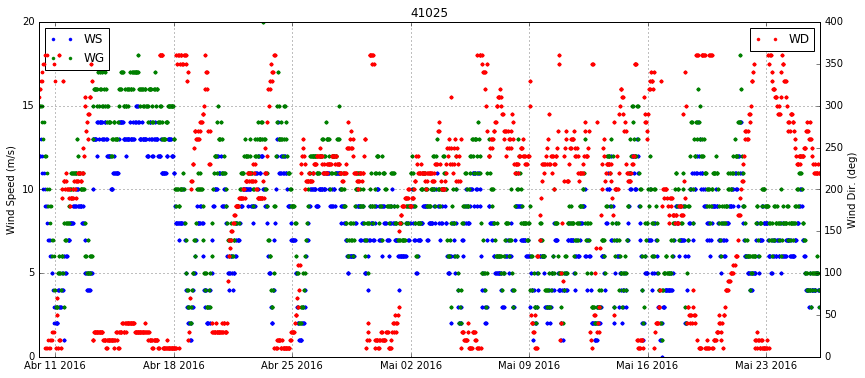

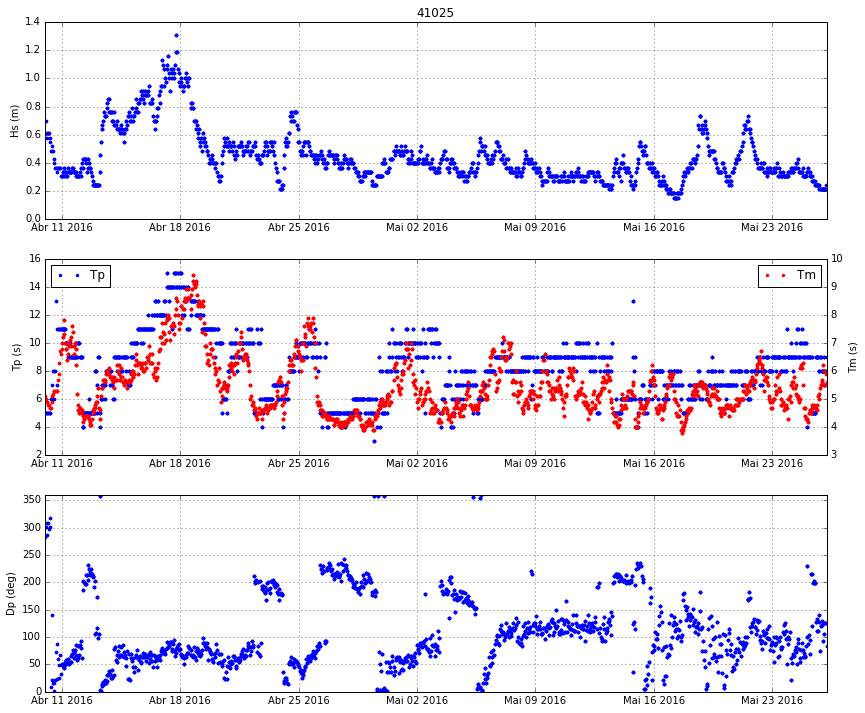

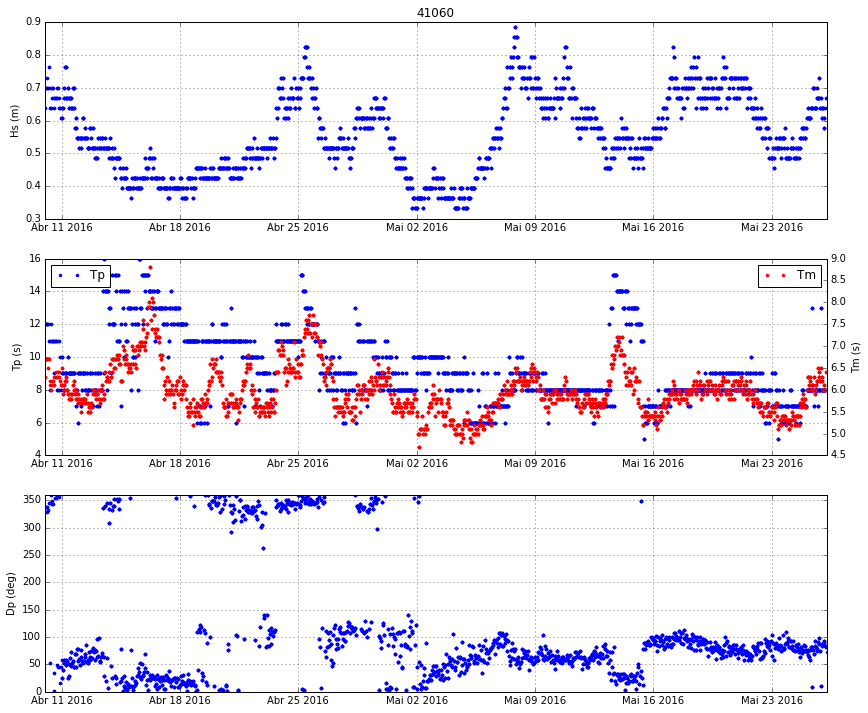

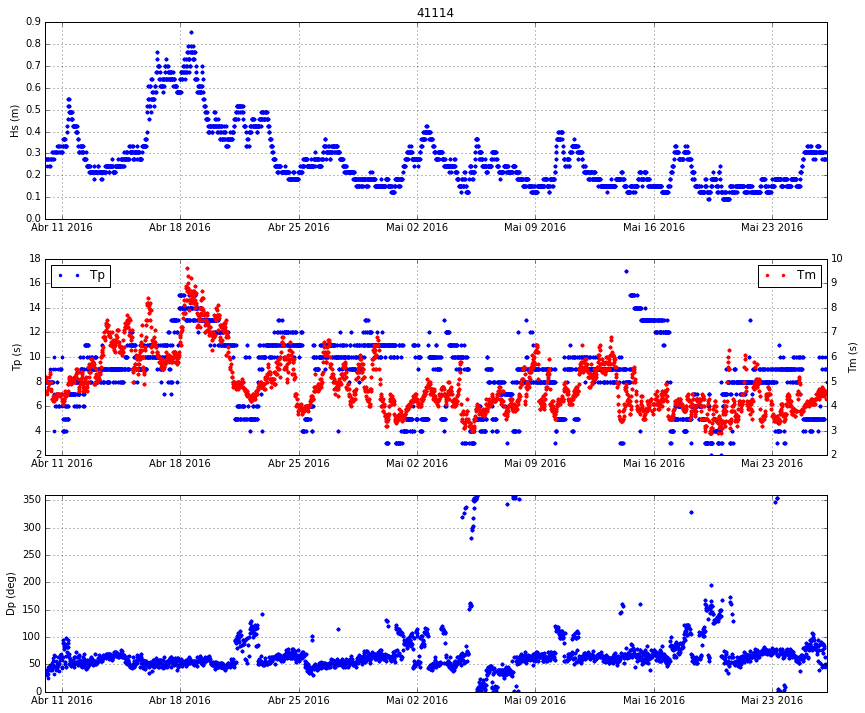

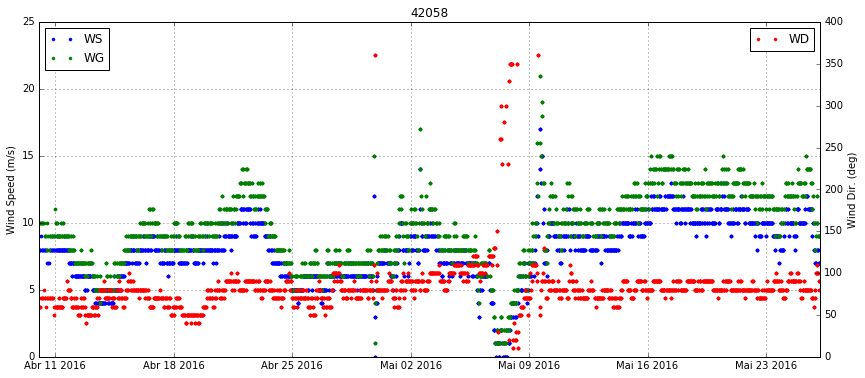

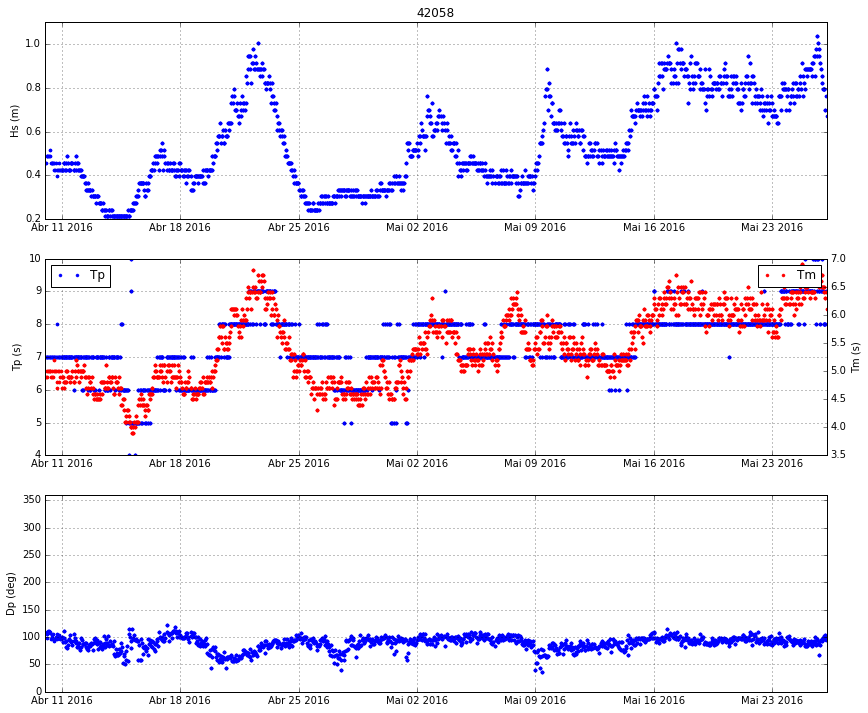

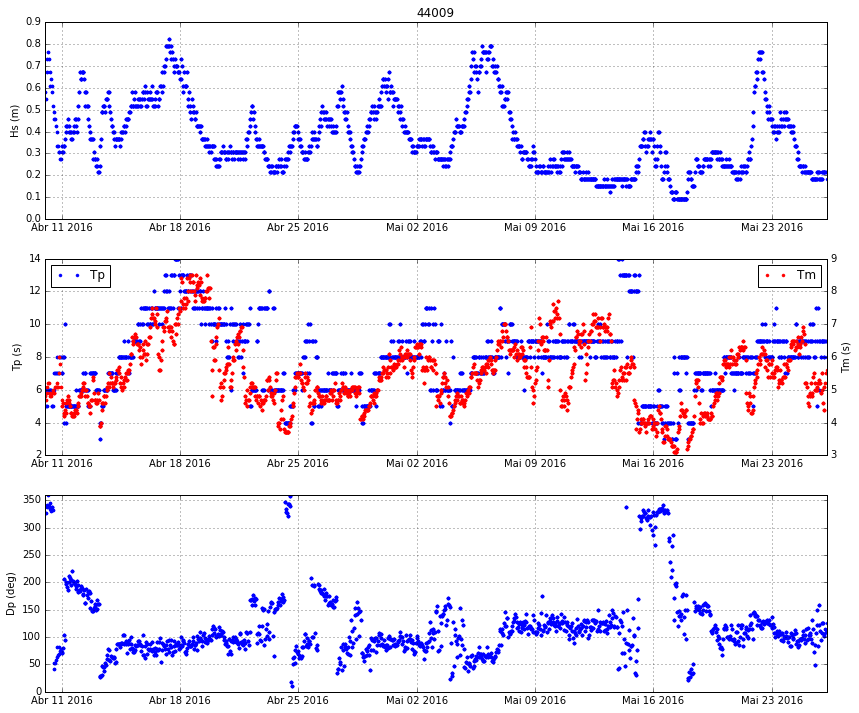

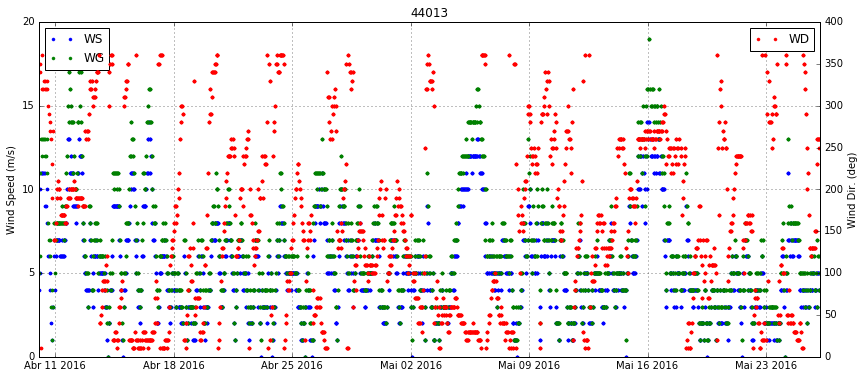

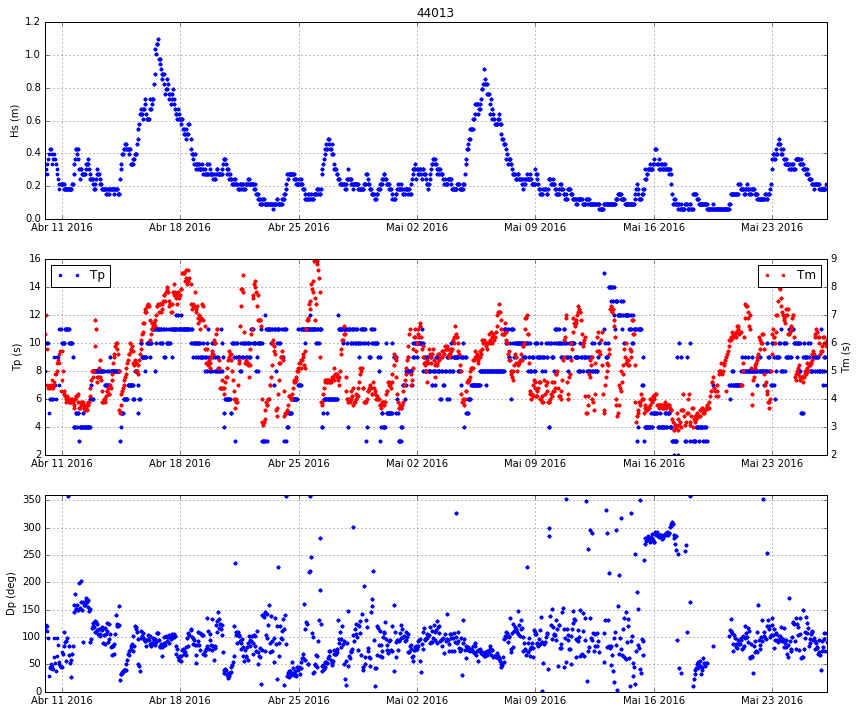

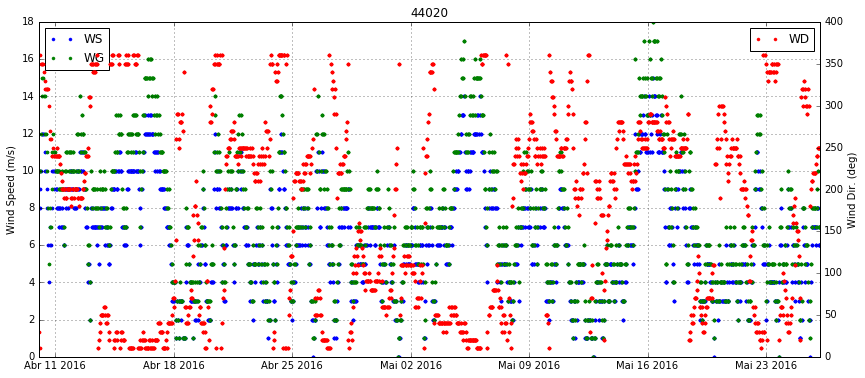

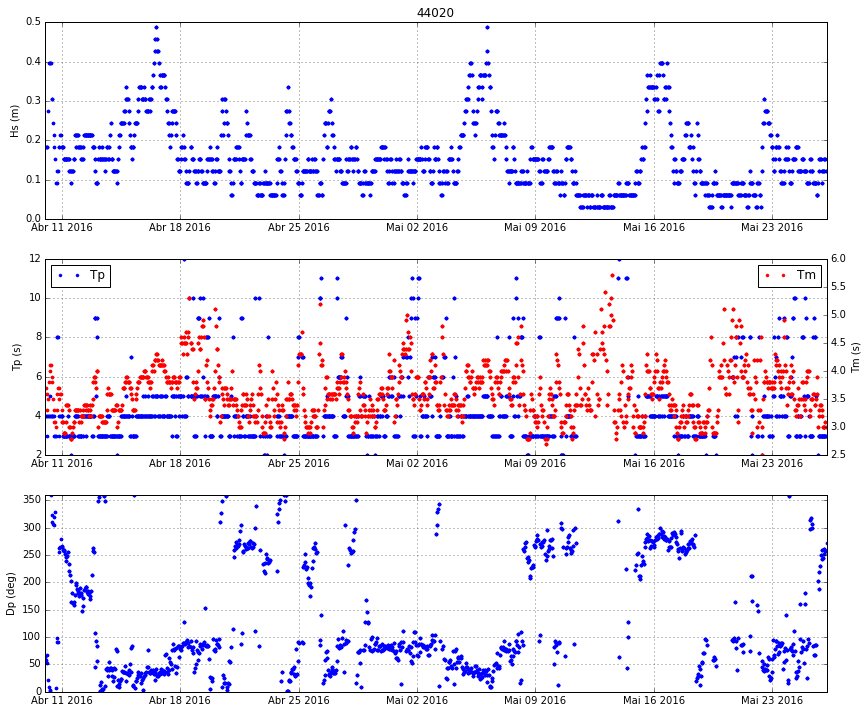

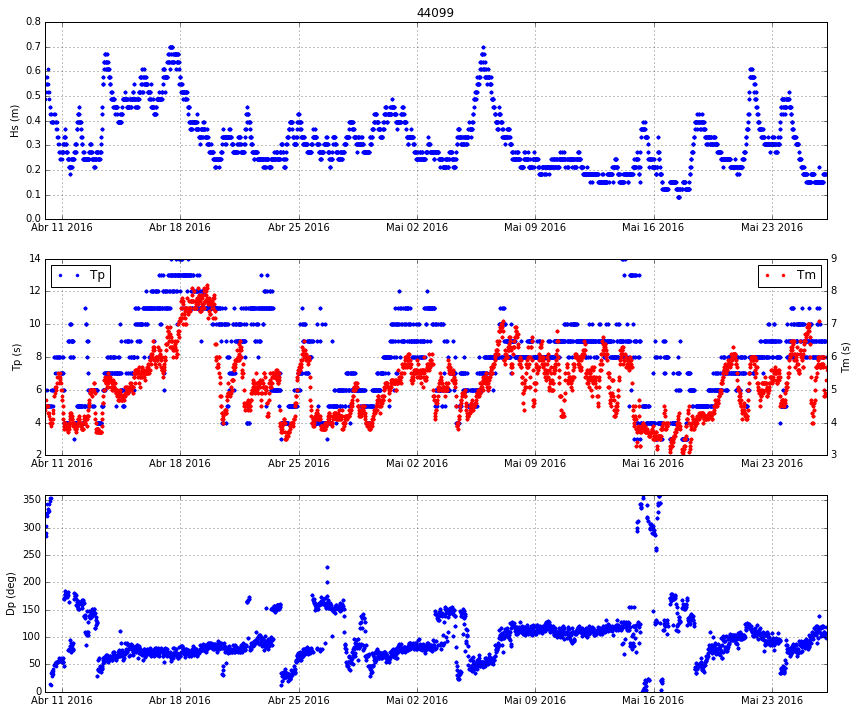

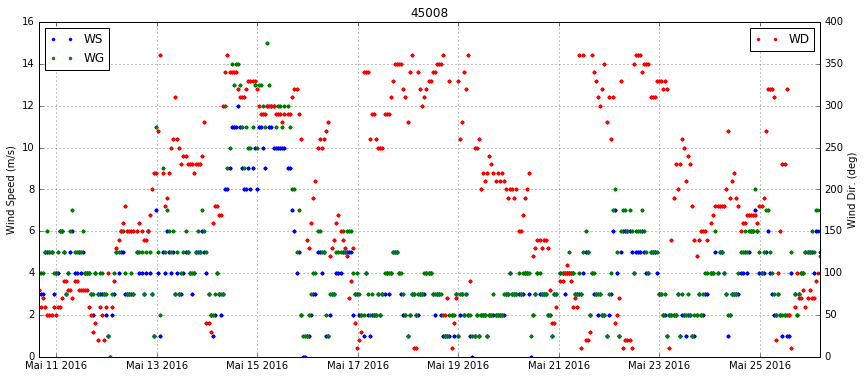

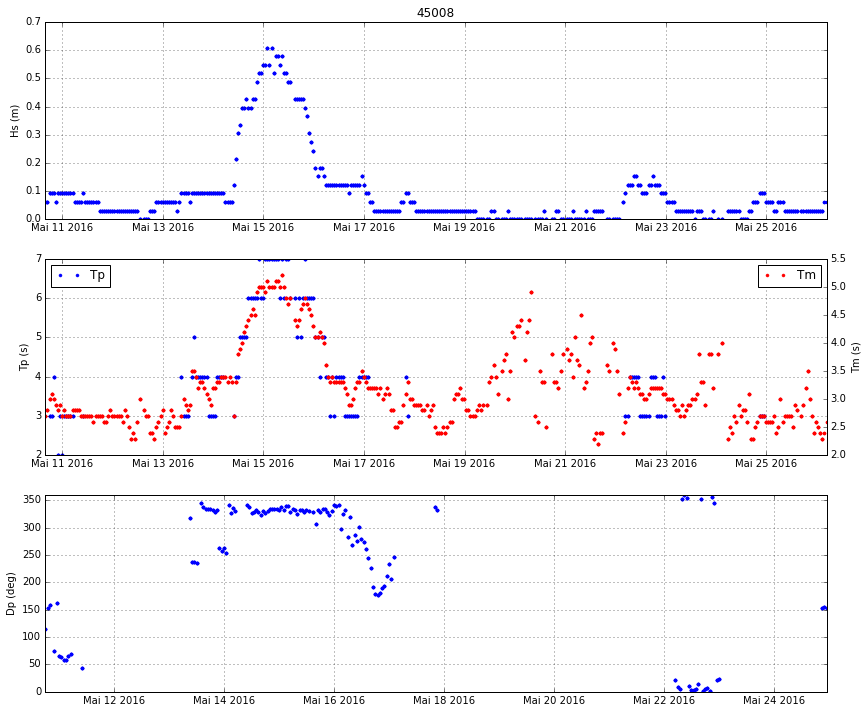

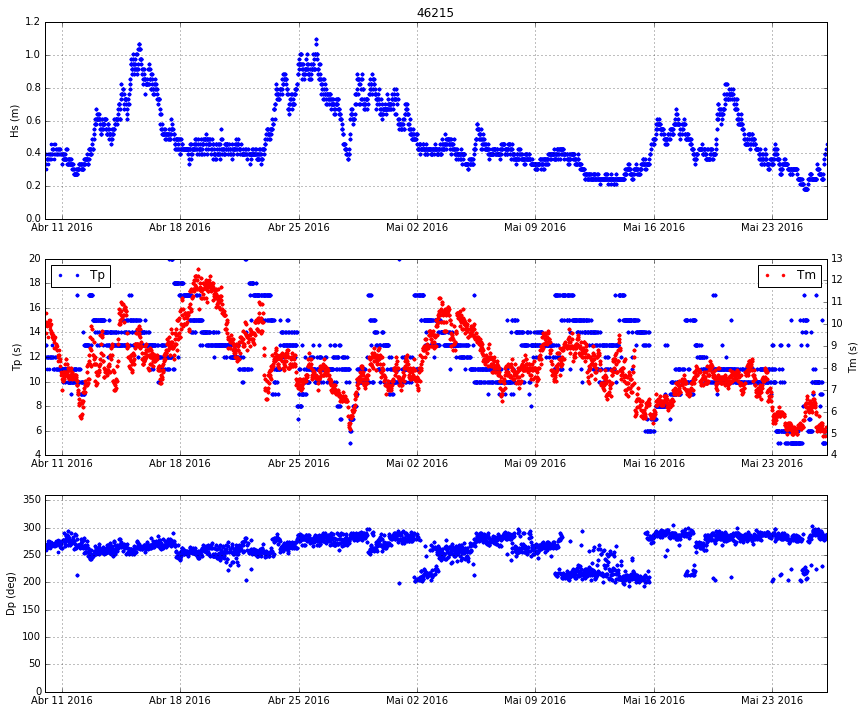

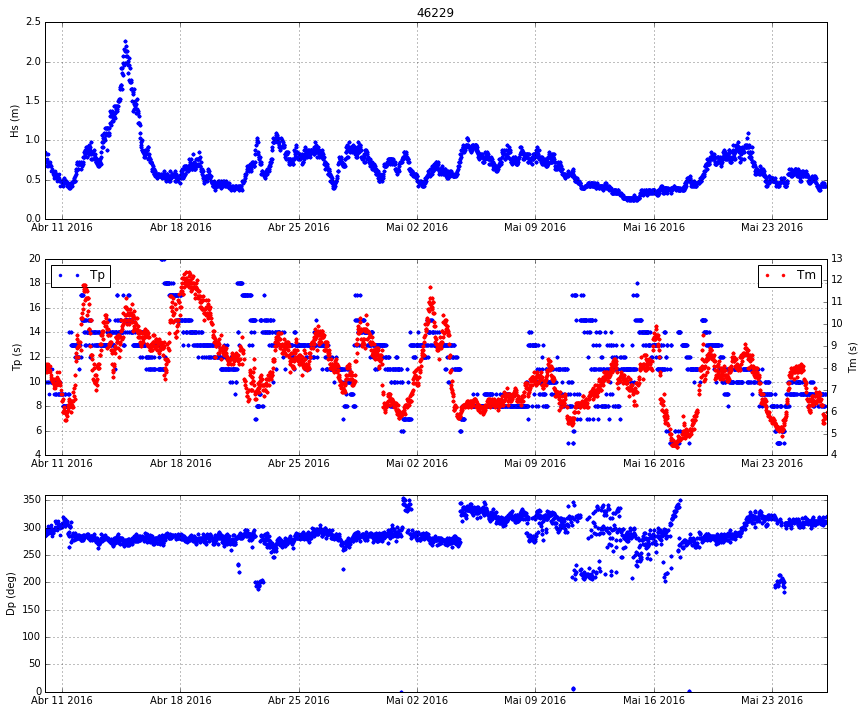

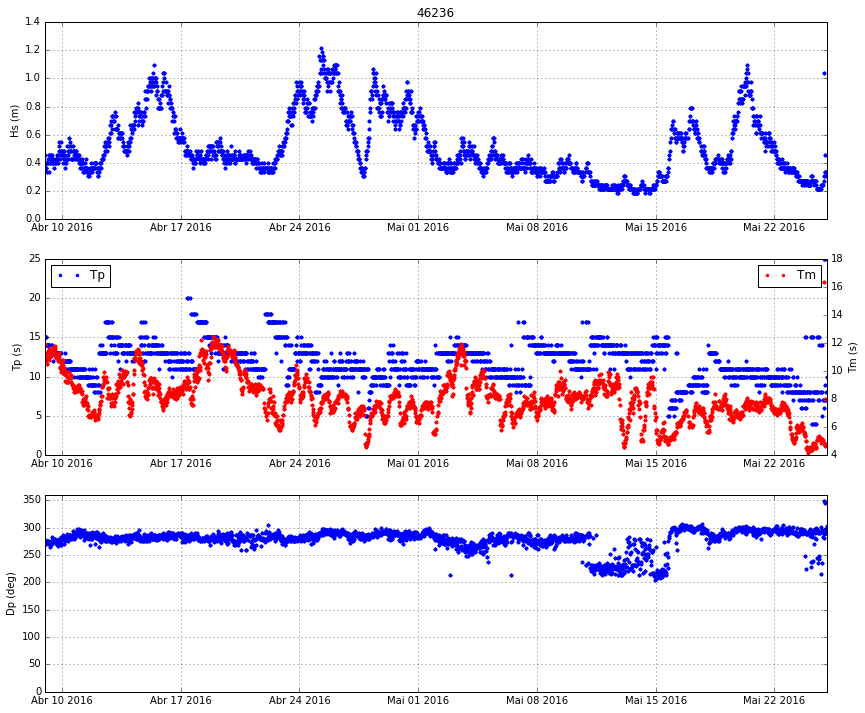

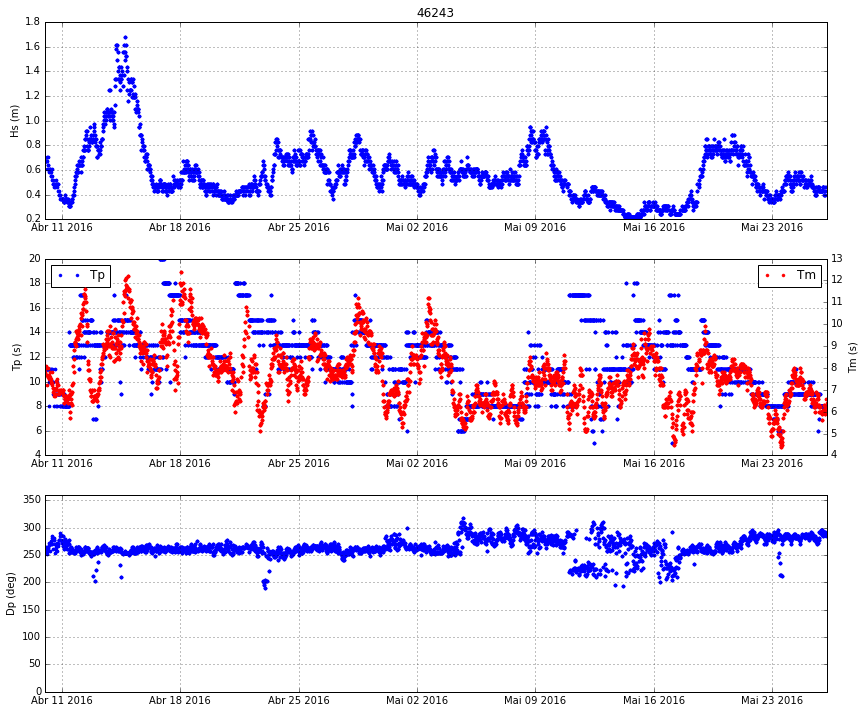

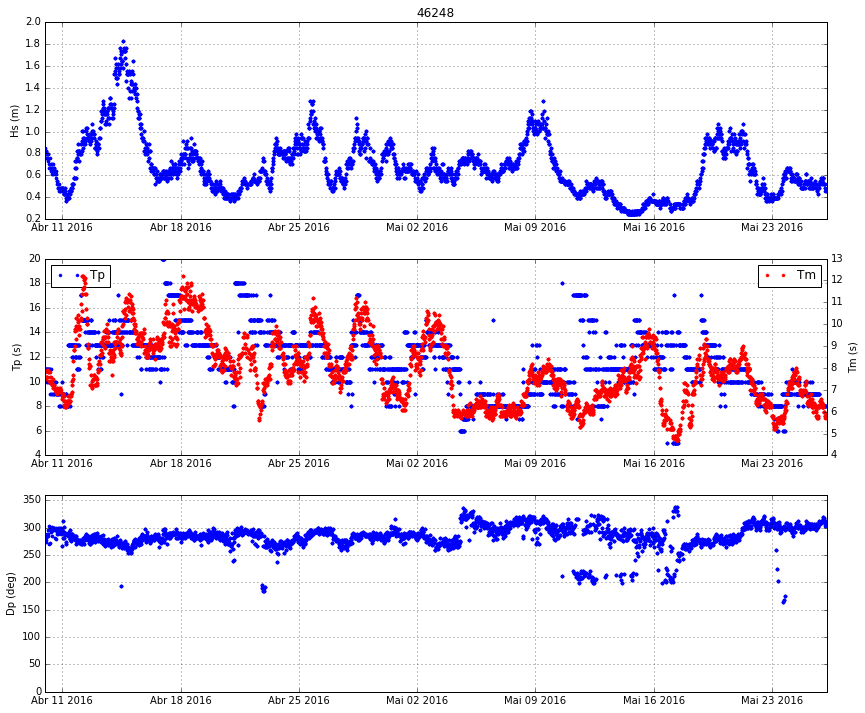

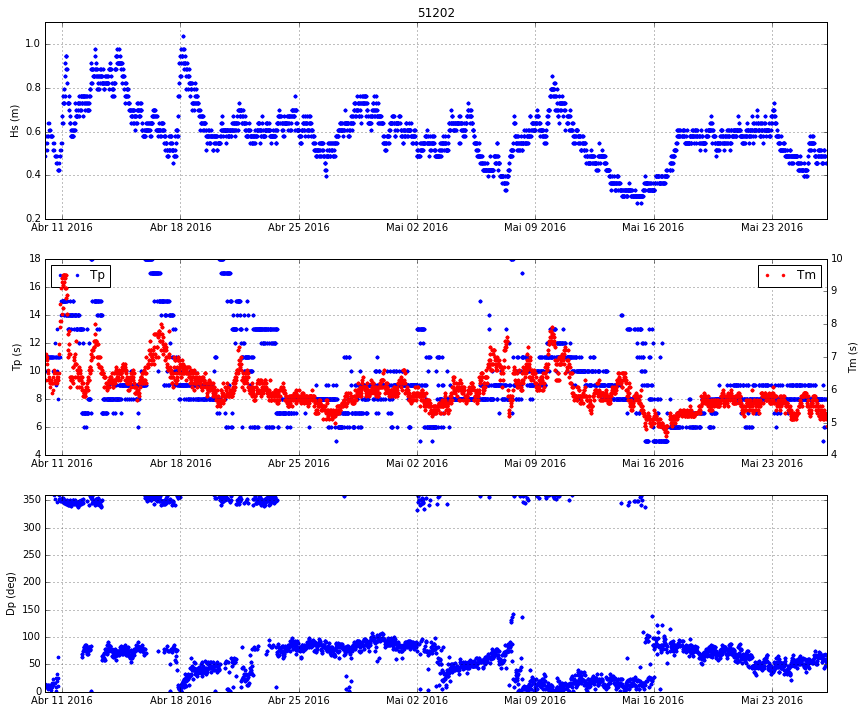

In [600]:
'''Make Figures'''

#pathname and station names
pathname = os.environ['HOME'] + '/Dropbox/database/ndbc/realtime/'

stations = ['32012','41001','41002','41013','41025','41060','41114',
            '42058','44009','44013','44020','44099','45008','46215',
            '46229','46236','46243','46248','51202']

for station in stations:
    
    dd = pd.read_csv(pathname + station + '.csv', sep=',', parse_dates=['date'], index_col=['date'])

    if dd.WSPD.isnull().all() == False:

        fig = plt.figure(figsize=(14,6))
        ax1 = fig.add_subplot(111)
        ax1.plot(dd.index, dd.WSPD, '.b', dd.index, dd.GST, '.g')
        ax1.set_title(station)
        ax1.grid()
        ax1.set_ylabel('Wind Speed (m/s)')
        ax1.legend(['WS','WG'], loc=2)
        ax12 = ax1.twinx()
        ax12.plot(dd.index, dd.WDIR, '.r')
        ax12.set_ylabel('Wind Dir. (deg)')
        ax12.legend(['WD'], loc=1)

    if dd.WVHT.isnull().all() == False:

        fig = plt.figure(figsize=(14,12))
        ax1 = fig.add_subplot(311)
        ax1.plot(dd.index, dd.WVHT, '.b')
        ax1.set_title(station)
        ax1.grid()
        ax1.set_ylabel('Hs (m)')
        ax2 = fig.add_subplot(312)
        ax2.plot(dd.index, dd.DPD, '.b') #, dd.index, dd.APD, '.r')
        ax2.grid()
        ax2.set_ylabel('Tp (s)')
        ax2.legend(['Tp'], loc=2)
        ax21 = ax2.twinx()
        ax21.plot(dd.index, dd.APD, '.r')
        ax21.set_ylabel('Tm (s)')
        ax21.legend(['Tm'], loc=1)
        ax3 = fig.add_subplot(313)
        ax3.plot(dd.index, dd.MWD, '.b')
        ax3.set_ylim(0,360)
        ax3.grid()
        ax3.set_ylabel('Dp (deg)')
        # ax3.set_yticklabels(ax3.get_yticks(), np.arange(0,360+45,45))